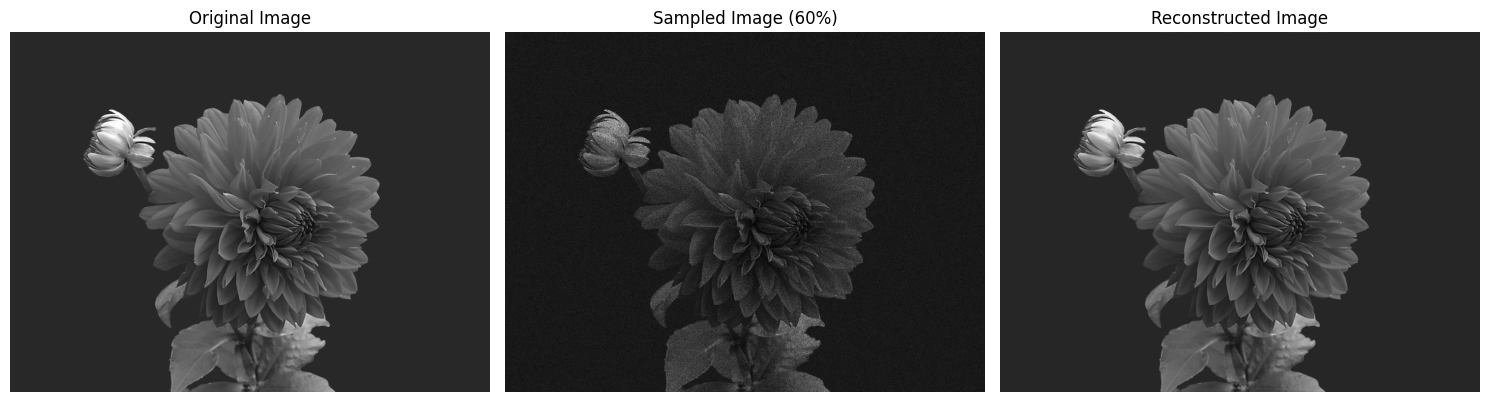

Convergence plot:


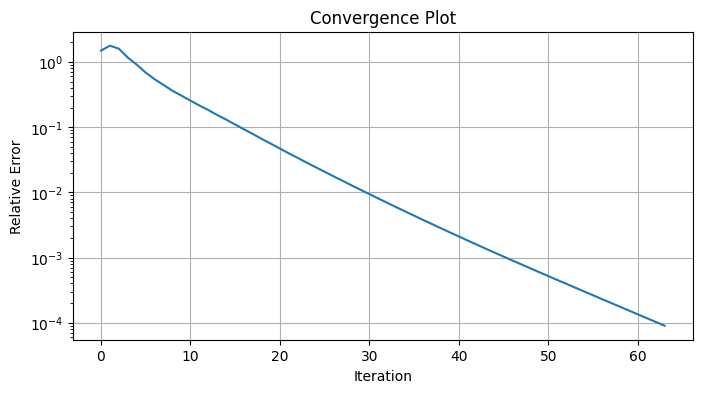

Final relative error: 0.000090


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def apply_q(Y, M, lambda_val):
    R = apply_qr(Y)
    return M * Y + lambda_val * R

def apply_qr(Y):
    R = np.zeros_like(Y)

    Y_pad = np.pad(Y, ((1,1), (1,1)), mode='wrap')

    temp = -2*Y + np.roll(Y, 1, axis=0) + np.roll(Y, -1, axis=0)
    R += (-2)*temp + np.roll(temp, 1, axis=0) + np.roll(temp, -1, axis=0)

    temp = -2*Y + np.roll(Y, 1, axis=1) + np.roll(Y, -1, axis=1)
    R += (-2)*temp + np.roll(temp, 1, axis=1) + np.roll(temp, -1, axis=1)

    temp = Y + np.roll(np.roll(Y, 1, axis=0), 1, axis=1) - \
           np.roll(Y, 1, axis=0) - np.roll(Y, 1, axis=1)
    R += temp + np.roll(np.roll(temp, -1, axis=0), -1, axis=1) - \
         np.roll(temp, -1, axis=0) - np.roll(temp, -1, axis=1)

    return R

def conjugate_gradient(M, G, lambda_val, epsilon):

    n, m = M.shape
    Y = np.zeros((n, m))
    R = G - apply_q(Y, M, lambda_val)
    P = R.copy()
    delta_new = np.sum(R**2)
    delta_0 = delta_new

    errors = []
    max_iter = 1000
    iter_count = 0

    while (np.sqrt(delta_new)/np.linalg.norm(G) > epsilon) and (iter_count < max_iter):
        Q_p = apply_q(P, M, lambda_val)

        alpha = delta_new / np.sum(P * Q_p)

        Y = Y + alpha * P

        R = R - alpha * Q_p

        delta_old = delta_new
        delta_new = np.sum(R**2)

        beta = delta_new / delta_old
        P = R + beta * P
        errors.append(np.sqrt(delta_new)/np.linalg.norm(G))
        iter_count += 1

    return Y, errors


def process_single_image(image_path, lambda_val=1.0, epsilon=1e-4):

    img = Image.open(image_path).convert('L')  # Convert to grayscale
    X = np.array(img, dtype=np.float64) / 255.0
    n, m = X.shape


    M = np.random.rand(n, m) < 0.6

    G = M * X

    X_hat, errors = conjugate_gradient(M, G, lambda_val, epsilon)

    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(X, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(G, cmap='gray')
    plt.title('Sampled Image (60%)')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(X_hat, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print('Convergence plot:')
    plt.figure(figsize=(8, 4))
    plt.semilogy(errors)
    plt.xlabel('Iteration')
    plt.ylabel('Relative Error')
    plt.title('Convergence Plot')
    plt.grid(True)
    plt.show()

    return X, M, G, X_hat, errors

if __name__ == "__main__":
    image_path = "/content/pexels-pixabay-60597.jpg"

    X, M, G, X_hat, errors = process_single_image(
        image_path,
        lambda_val=1.0,
        epsilon=1e-4
    )

    print(f"Final relative error: {errors[-1]:.6f}")

Analyzing single image...
Testing epsilon = 1e-06
Reconstruction error: 444.9984162208262
Testing epsilon = 1e-05
Reconstruction error: 444.9981436450372
Testing epsilon = 0.0001
Reconstruction error: 445.00087000730537
Testing epsilon = 0.001
Reconstruction error: 445.213619033321
Testing epsilon = 0.01
Reconstruction error: 459.9062050481339
Testing epsilon = 0.1
Reconstruction error: 1562.2996343163825


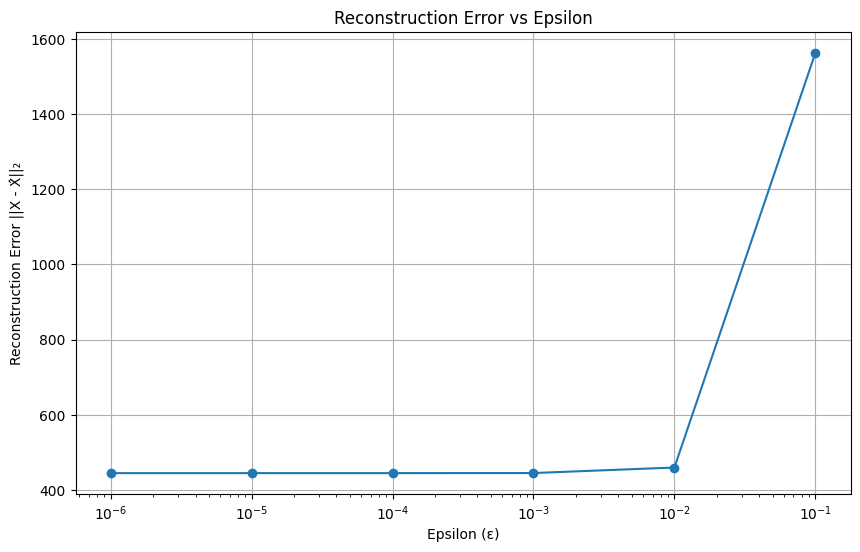

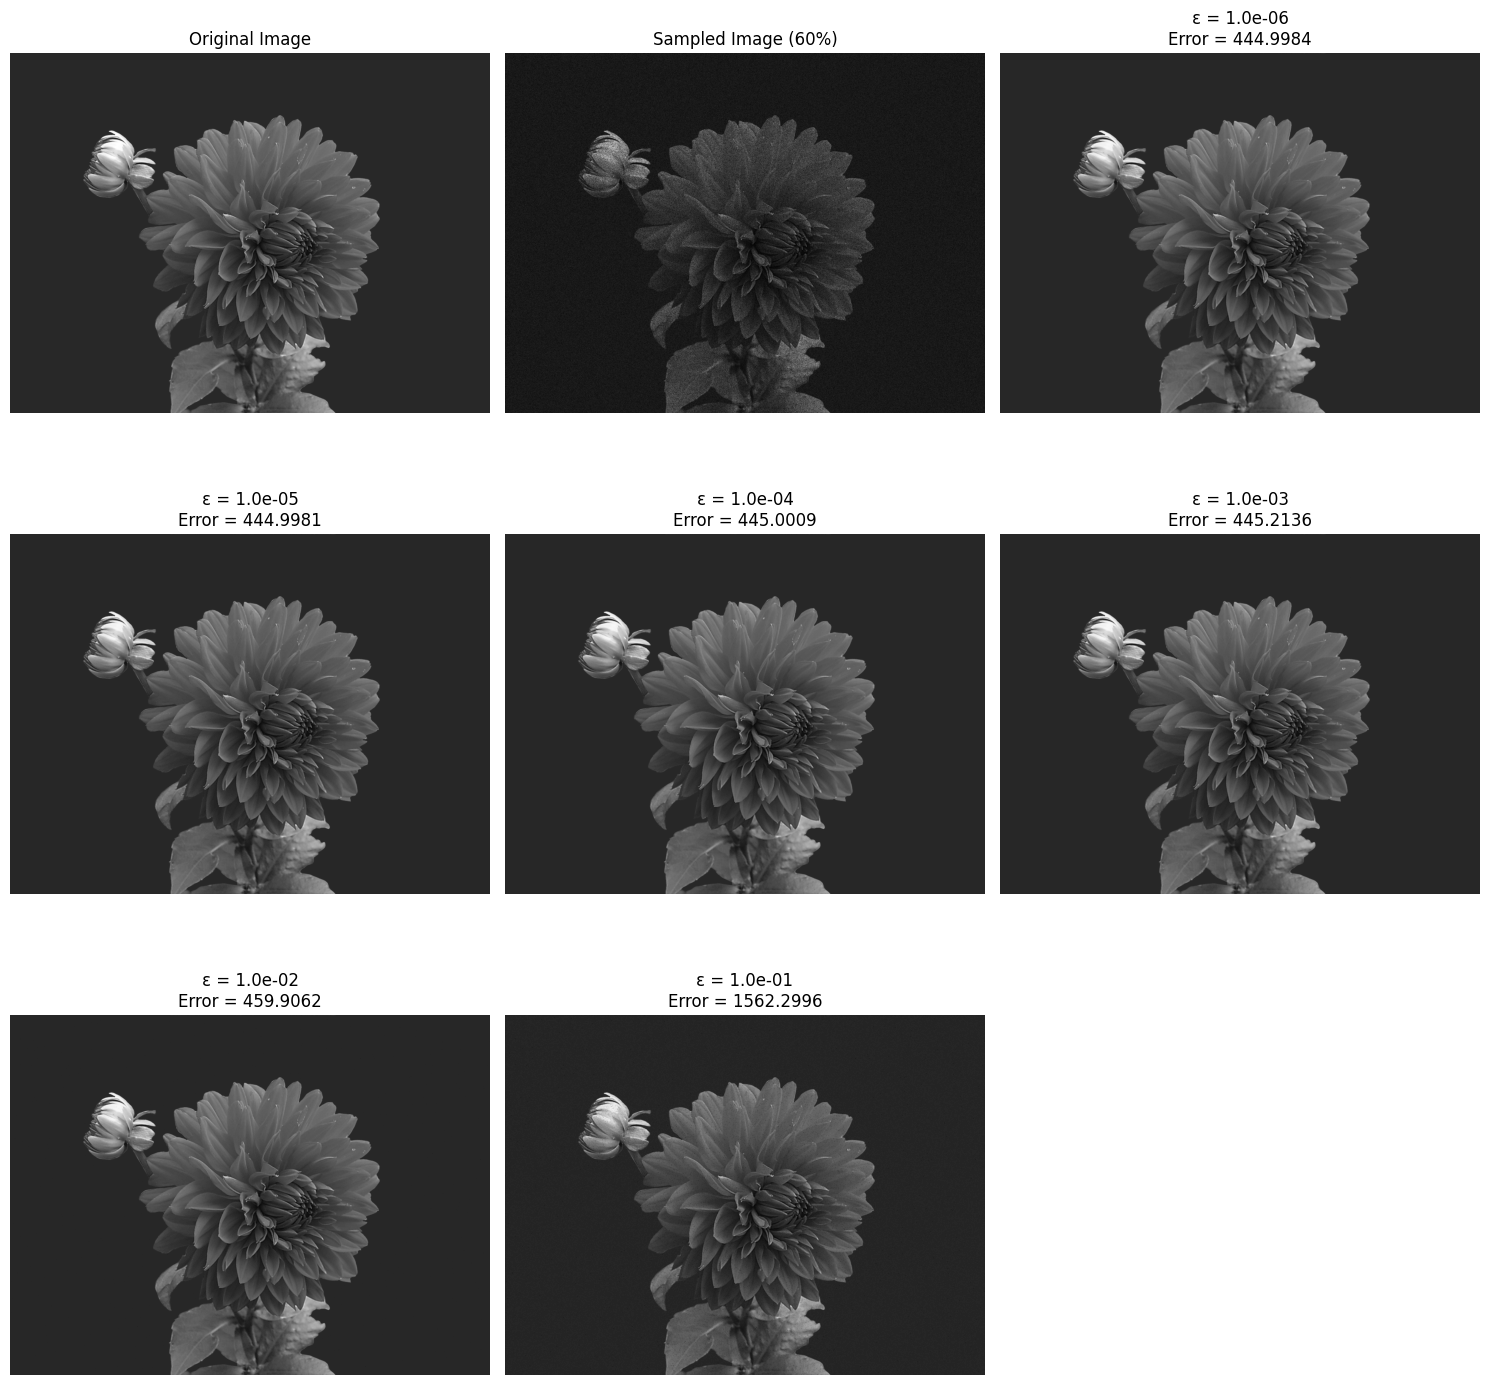


Results:
Epsilon values tested: [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
Corresponding reconstruction errors: [444.9984162208262, 444.9981436450372, 445.00087000730537, 445.213619033321, 459.9062050481339, 1562.2996343163825]

Best epsilon value: 1e-05
Minimum reconstruction error: 444.9981436450372


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def analyze_epsilon_values(image_path, lambda_val=1.0):

    img = Image.open(image_path).convert('L')
    X = np.array(img, dtype=np.float64) / 255.0
    n = X.shape[0]

    M = np.random.rand(*X.shape) < 0.6

    G = M * X

    epsilon_values = np.logspace(-6, -1, 6)
    reconstruction_errors = []
    all_X_hats = []

    for epsilon in epsilon_values:
        print(f"Testing epsilon = {epsilon}")
        X_hat, errors = conjugate_gradient(M, G, lambda_val, epsilon)
        error = np.linalg.norm(X - X_hat)**2
        reconstruction_errors.append(error)
        all_X_hats.append(X_hat)

        print(f"Reconstruction error: {error}")

    plt.figure(figsize=(10, 6))
    plt.semilogx(epsilon_values, reconstruction_errors, '-o')
    plt.grid(True)
    plt.xlabel('Epsilon (ε)')
    plt.ylabel('Reconstruction Error ||X - X̂||₂')
    plt.title('Reconstruction Error vs Epsilon')
    plt.show()

    n_cols = 3
    n_rows = (len(epsilon_values) + 1) // n_cols + 1

    plt.figure(figsize=(15, 5 * n_rows))

    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(X, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(n_rows, n_cols, 2)
    plt.imshow(G, cmap='gray')
    plt.title('Sampled Image (60%)')
    plt.axis('off')

    for i, (eps, X_hat) in enumerate(zip(epsilon_values, all_X_hats)):
        plt.subplot(n_rows, n_cols, i + 3)
        plt.imshow(X_hat, cmap='gray')
        plt.title(f'ε = {eps:.1e}\nError = {reconstruction_errors[i]:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return epsilon_values, reconstruction_errors, all_X_hats


if __name__ == "__main__":
    image_path = "/content/pexels-pixabay-60597.jpg"

    print("Analyzing single image...")
    epsilon_values, errors, X_hats = analyze_epsilon_values(image_path)

    print("\nResults:")
    print("Epsilon values tested:", epsilon_values)
    print("Corresponding reconstruction errors:", errors)

    best_epsilon_idx = np.argmin(errors)
    print(f"\nBest epsilon value: {epsilon_values[best_epsilon_idx]}")
    print(f"Minimum reconstruction error: {errors[best_epsilon_idx]}")


Basic lambda analysis...
Testing lambda = 0.001
Reconstruction error: 14985796.81390181
Testing lambda = 0.01
Reconstruction error: 7142770.919902837
Testing lambda = 0.1
Reconstruction error: 11149160.010697339
Testing lambda = 1.0
Reconstruction error: 28863610.16044292
Testing lambda = 10.0
Reconstruction error: 76407685.16793756
Testing lambda = 100.0
Reconstruction error: 191849096.69487864
Testing lambda = 1000.0
Reconstruction error: 396257659.33331096


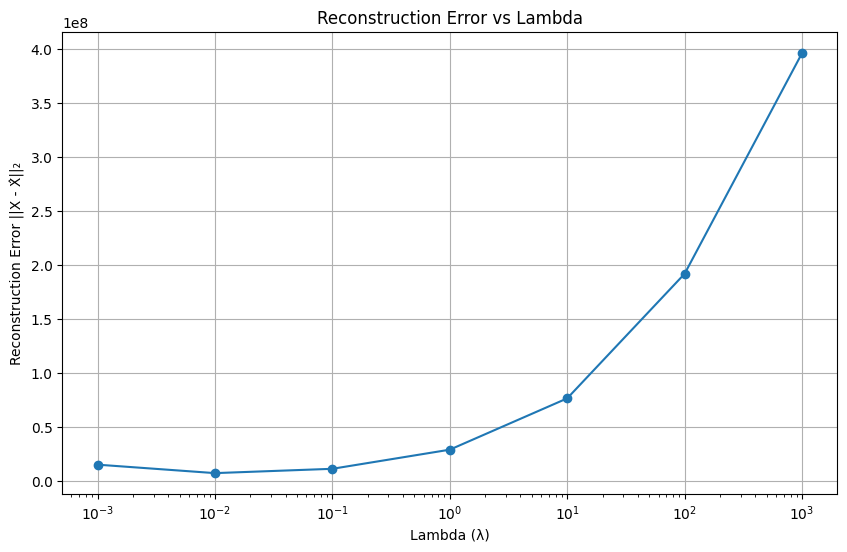

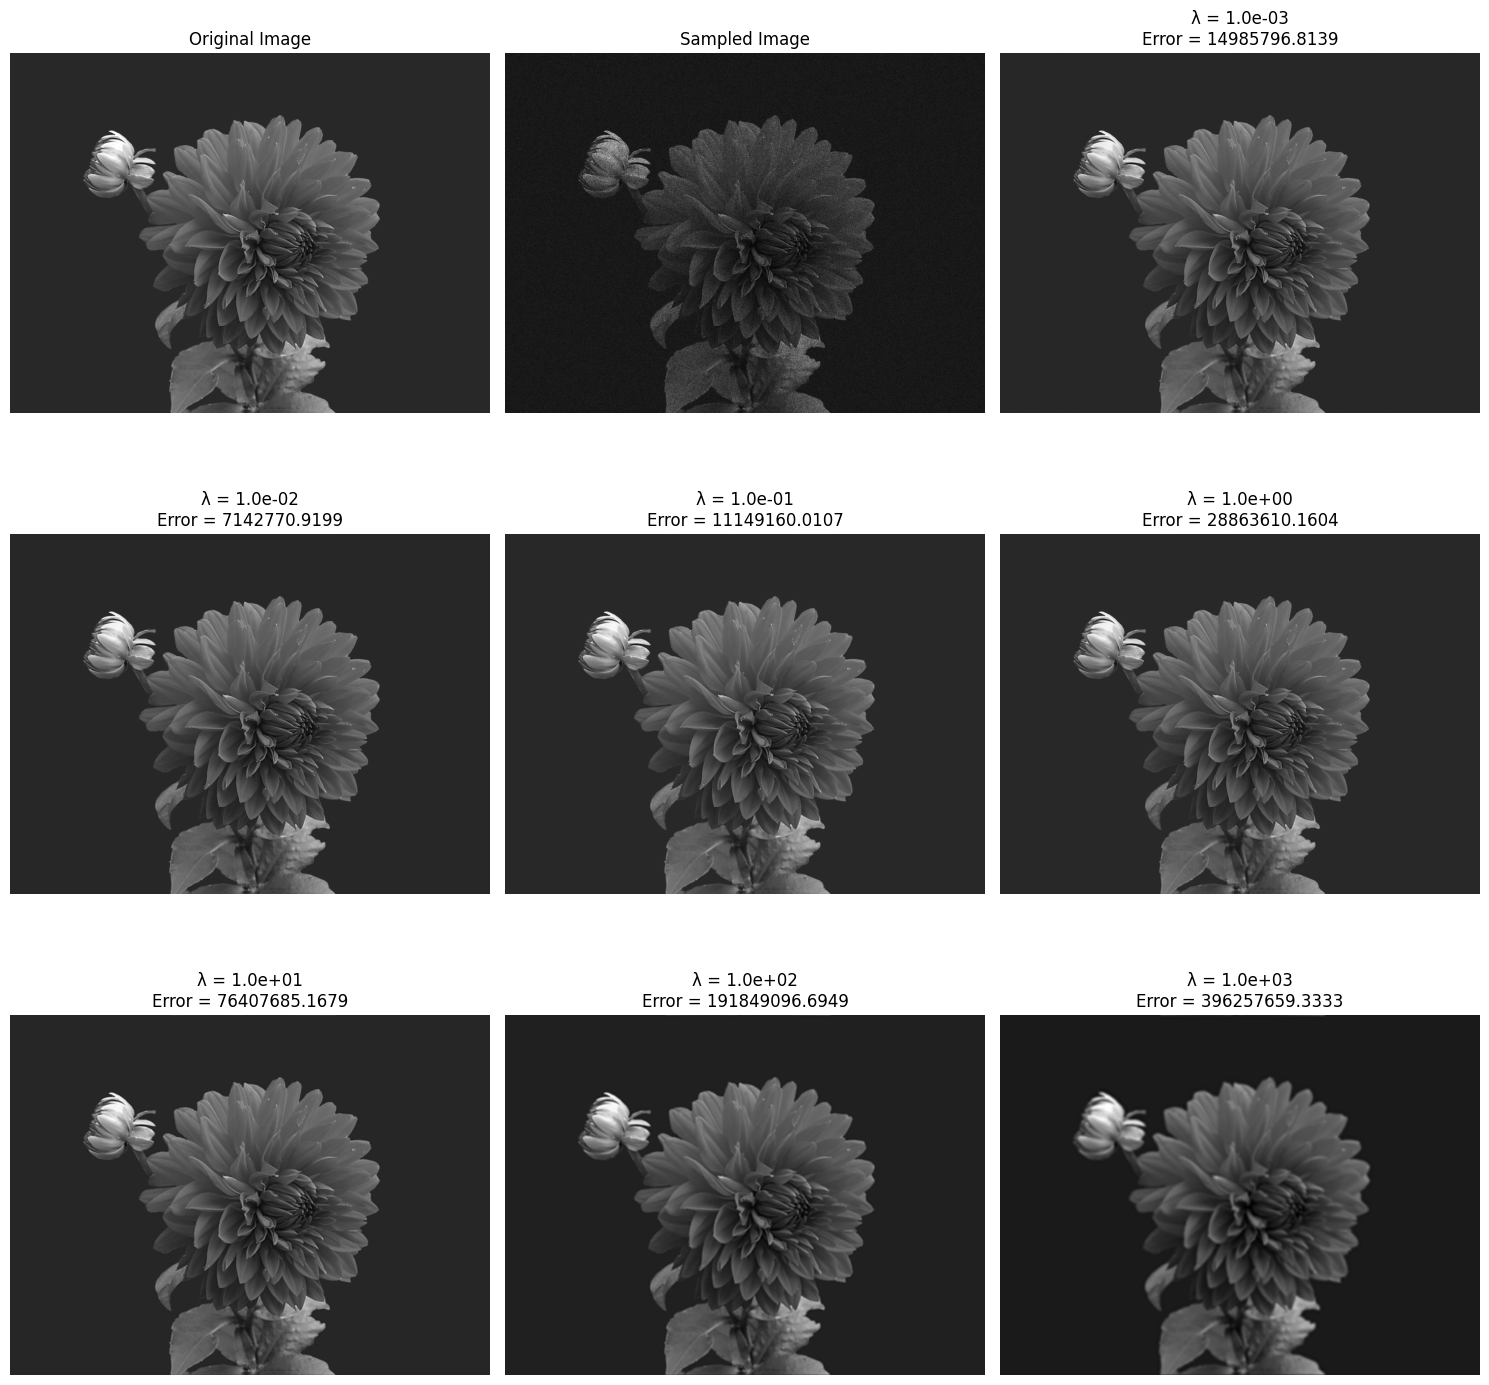


Results:
Lambda values tested: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
Corresponding reconstruction errors: [14985796.81390181, 7142770.919902837, 11149160.010697339, 28863610.16044292, 76407685.16793756, 191849096.69487864, 396257659.33331096]

Best lambda value: 0.01
Minimum reconstruction error: 7142770.919902837

Performing detailed analysis around best lambda region...


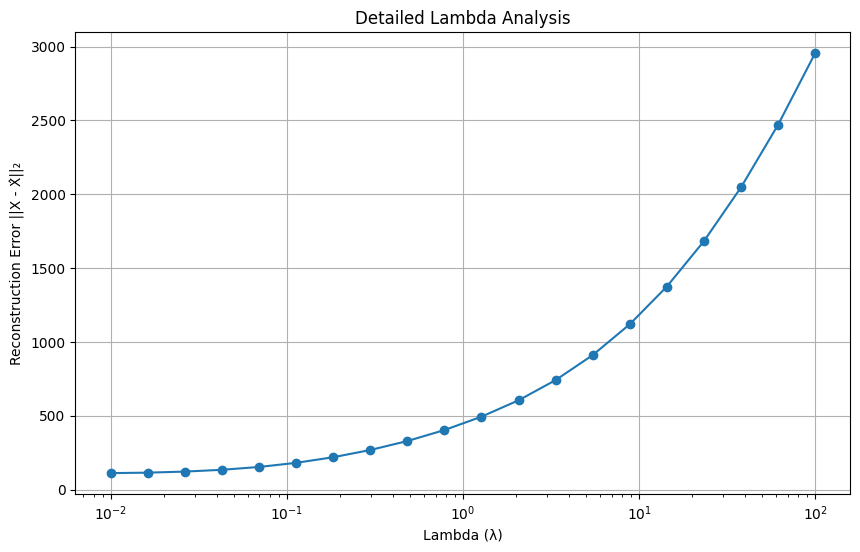

Optimal lambda value: 0.01
Minimum error: 111.06446453347907

Analyzing multiple images...

Analyzing image: image1.png


FileNotFoundError: [Errno 2] No such file or directory: '/content/image1.png'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def analyze_lambda_values(image_path, epsilon=1e-4):

    image = Image.open(image_path).convert("L")
    X = np.array(image)

    mask_percentage = 0.6
    M = np.random.choice([0, 1], size=X.shape, p=[1 - mask_percentage, mask_percentage])

    G = M * X

    lambda_values = np.logspace(-3, 3, 7)
    reconstruction_errors = []
    all_X_hats = []

    for lambda_val in lambda_values:
        print(f"Testing lambda = {lambda_val}")
        X_hat, errors = conjugate_gradient(M, G, lambda_val, epsilon)

        error = np.linalg.norm(X - X_hat)**2
        reconstruction_errors.append(error)
        all_X_hats.append(X_hat)

        print(f"Reconstruction error: {error}")

    plt.figure(figsize=(10, 6))
    plt.semilogx(lambda_values, reconstruction_errors, '-o')
    plt.grid(True)
    plt.xlabel('Lambda (λ)')
    plt.ylabel('Reconstruction Error ||X - X̂||₂')
    plt.title('Reconstruction Error vs Lambda')
    plt.show()

    n_cols = 3
    n_rows = (len(lambda_values) + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 5*n_rows))

    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(X, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(n_rows, n_cols, 2)
    plt.imshow(G, cmap='gray')
    plt.title('Sampled Image')
    plt.axis('off')

    for i, (lambda_val, X_hat) in enumerate(zip(lambda_values, all_X_hats)):
        plt.subplot(n_rows, n_cols, i+3)
        plt.imshow(X_hat, cmap='gray')
        plt.title(f'λ = {lambda_val:.1e}\nError = {reconstruction_errors[i]:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return lambda_values, reconstruction_errors, all_X_hats

def detailed_lambda_analysis(image_path):
    img = Image.open(image_path).convert('L')
    X = np.array(img, dtype=np.float64) / 255.0

    M = np.random.rand(*X.shape) < 0.6
    G = M * X

    lambda_values = np.logspace(-2, 2, 20)
    reconstruction_errors = []

    for lambda_val in lambda_values:
        X_hat, _ = conjugate_gradient(M, G, lambda_val, 1e-4)
        error = np.linalg.norm(X - X_hat)**2
        reconstruction_errors.append(error)

    plt.figure(figsize=(10, 6))
    plt.semilogx(lambda_values, reconstruction_errors, '-o')
    plt.grid(True)
    plt.xlabel('Lambda (λ)')
    plt.ylabel('Reconstruction Error ||X - X̂||₂')
    plt.title('Detailed Lambda Analysis')
    plt.show()

    best_lambda_idx = np.argmin(reconstruction_errors)
    best_lambda = lambda_values[best_lambda_idx]
    print(f"Optimal lambda value: {best_lambda}")
    print(f"Minimum error: {reconstruction_errors[best_lambda_idx]}")

    return best_lambda, reconstruction_errors[best_lambda_idx]


if __name__ == "__main__":
    image_path = "/content/pexels-pixabay-60597.jpg"

    print("Basic lambda analysis...")
    lambda_values, errors, X_hats = analyze_lambda_values(image_path)

    print("\nResults:")
    print("Lambda values tested:", lambda_values)
    print("Corresponding reconstruction errors:", errors)

    best_lambda_idx = np.argmin(errors)
    print(f"\nBest lambda value: {lambda_values[best_lambda_idx]}")
    print(f"Minimum reconstruction error: {errors[best_lambda_idx]}")

    print("\nPerforming detailed analysis around best lambda region...")
    optimal_lambda, min_error = detailed_lambda_analysis(image_path)

Starting analysis of multiple images...

Processing image 1/5: /content/pexels-pixabay-60597.jpg
Best lambda: 1.0000e-02, Error: 111.0225

Processing image 2/5: /content/pexels-jmark-250591.jpg
Best lambda: 1.0000e-02, Error: 1391.2155

Processing image 3/5: /content/pexels-nietjuh-1883385.jpg
Best lambda: 1.0000e-02, Error: 263.3112

Processing image 4/5: /content/pexels-pixabay-67857.jpg
Best lambda: 1.0000e-02, Error: 12666.9686

Processing image 5/5: /content/pexels-pixabay-68507.jpg
Best lambda: 1.0000e-02, Error: 807.7977


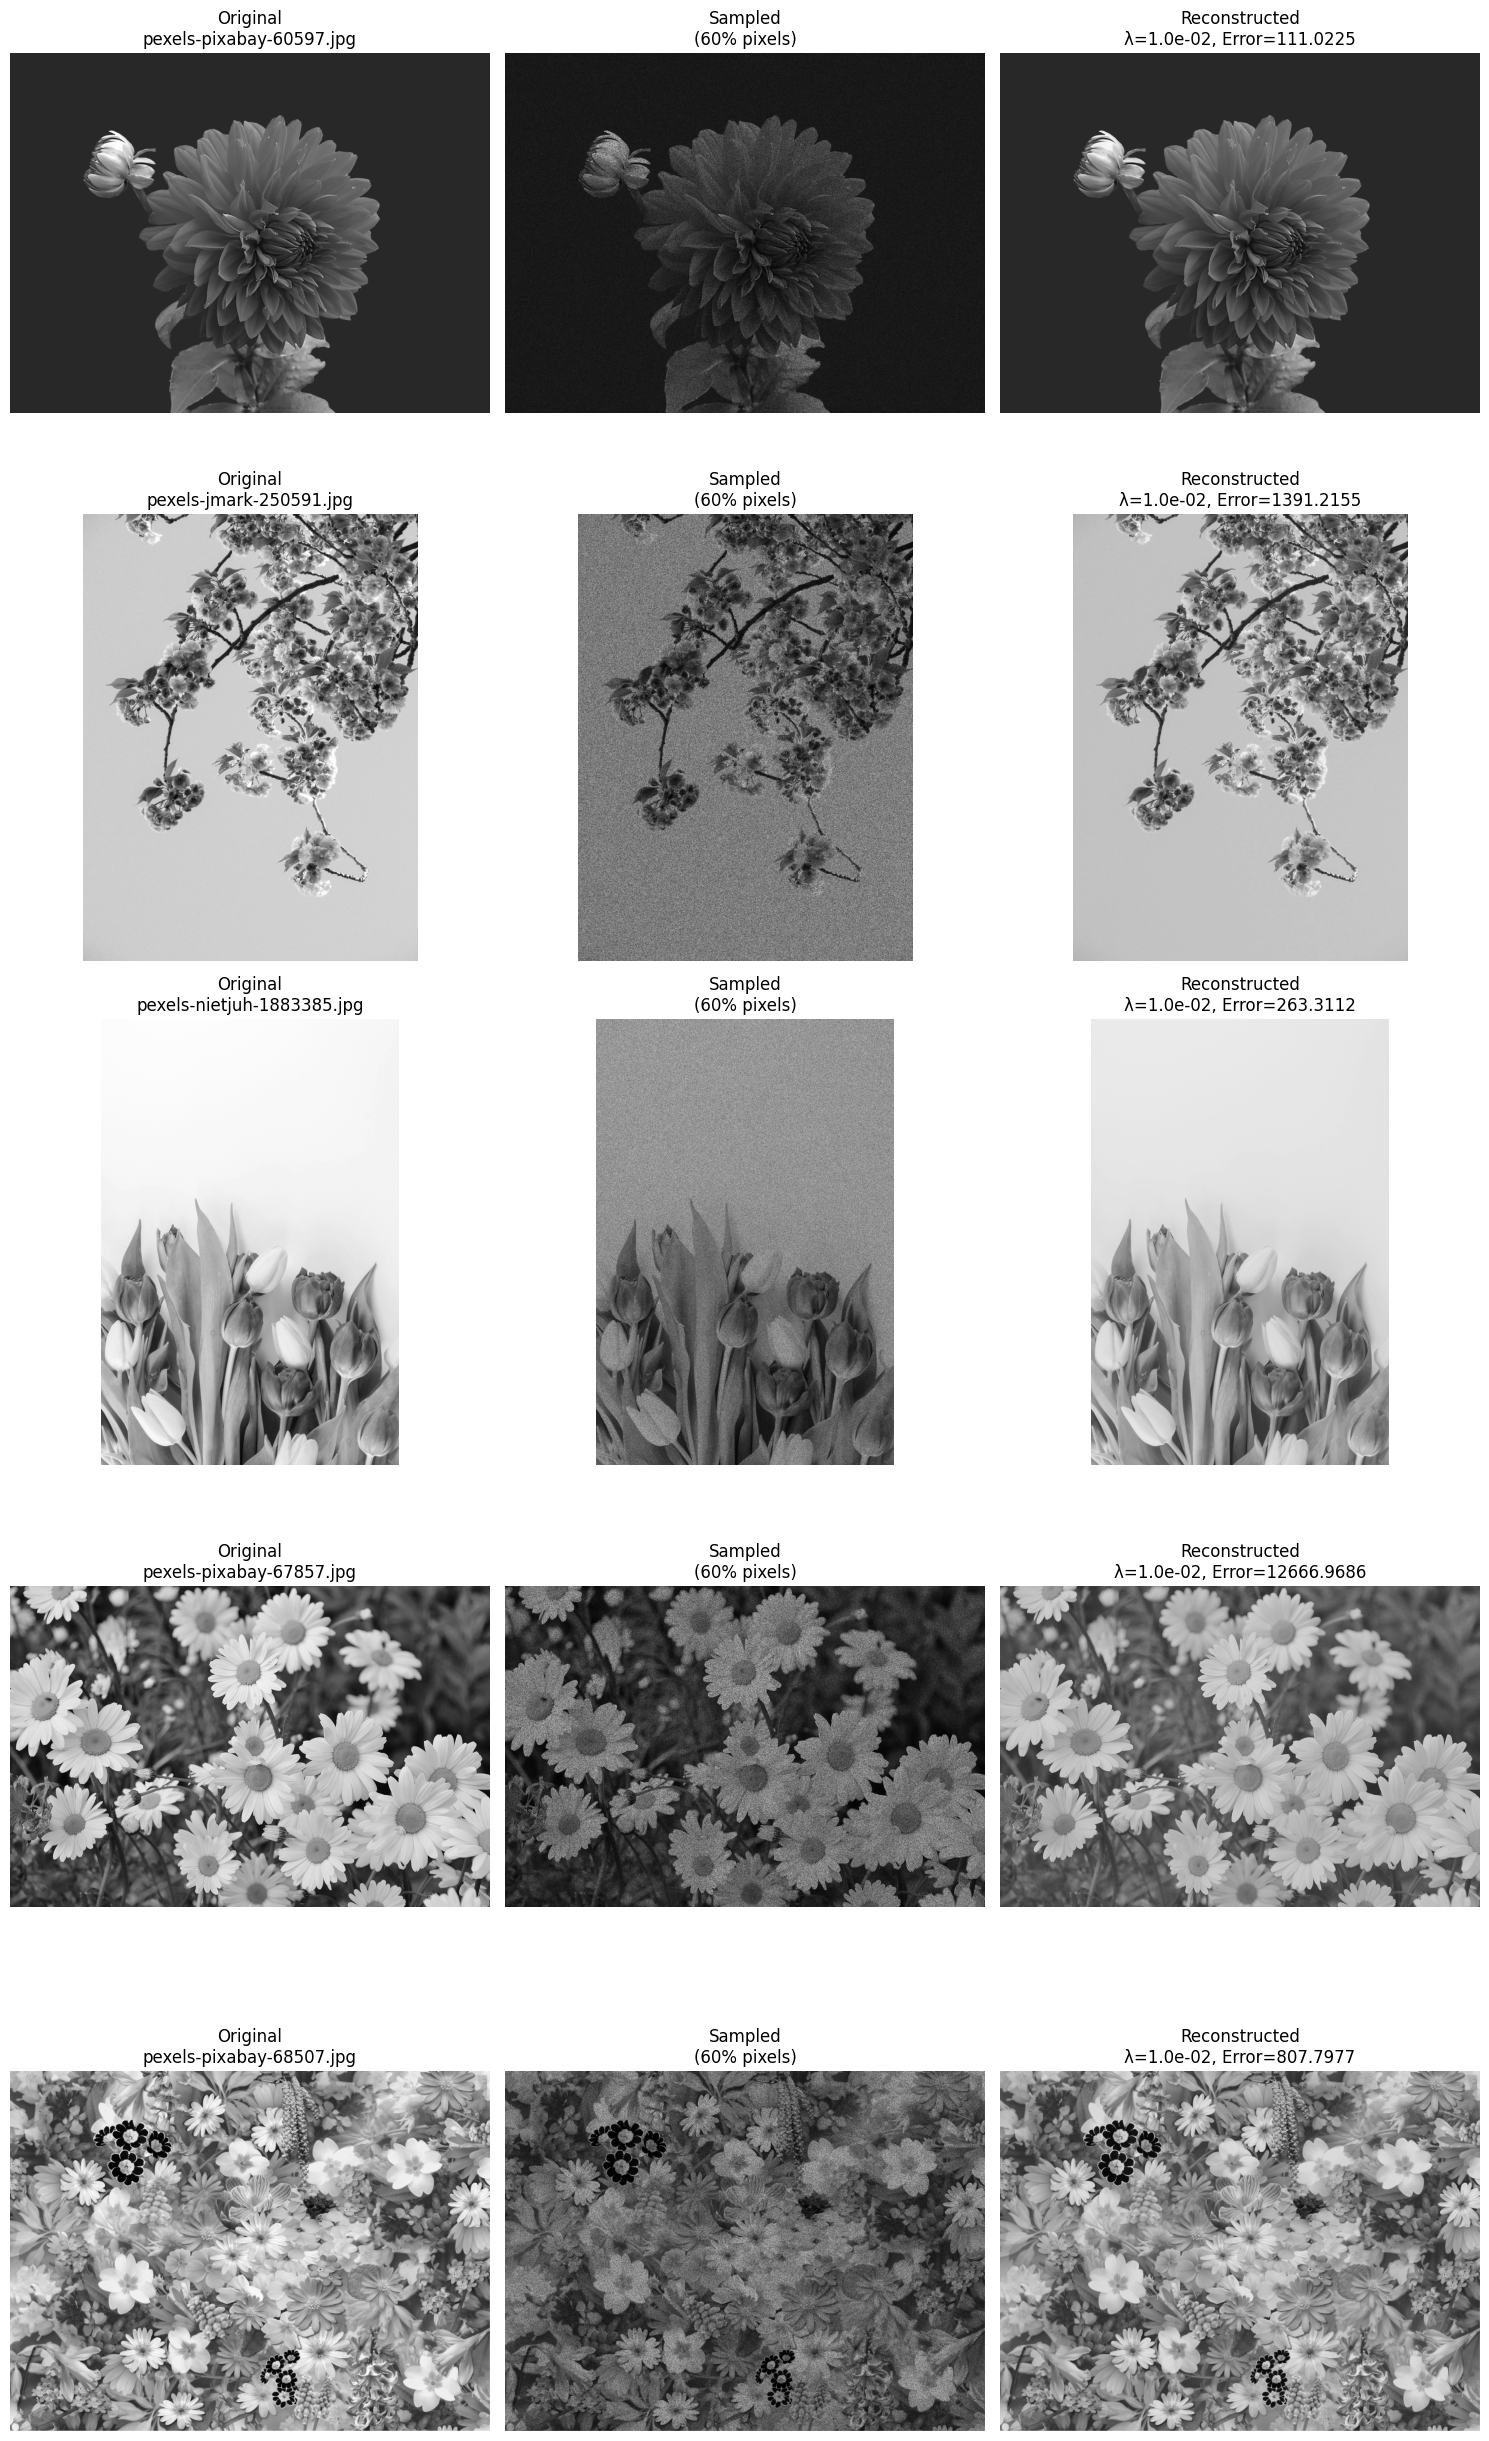


Summary of Results:
--------------------------------------------------------------------------------
Image                                   Best λ           Error
--------------------------------------------------------------------------------
pexels-pixabay-60597.jpg            1.0000e-02        111.0225
pexels-jmark-250591.jpg             1.0000e-02       1391.2155
pexels-nietjuh-1883385.jpg          1.0000e-02        263.3112
pexels-pixabay-67857.jpg            1.0000e-02      12666.9686
pexels-pixabay-68507.jpg            1.0000e-02        807.7977

Saving results...

Analysis complete! Results have been saved to the 'results' directory.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def find_best_lambda(X, M, G, epsilon=1e-4):
    lambda_values = np.logspace(-3, 3, 7)
    reconstruction_errors = []

    for lambda_val in lambda_values:
        X_hat, _ = conjugate_gradient(M, G, lambda_val, epsilon)
        error = np.linalg.norm(X - X_hat)**2
        reconstruction_errors.append(error)

    best_lambda_idx = np.argmin(reconstruction_errors)
    return lambda_values[best_lambda_idx], reconstruction_errors[best_lambda_idx]

def analyze_multiple_images(image_paths, epsilon=1e-4):
    results = {}
    n_images = len(image_paths)

    n_cols = 3
    n_rows = n_images
    plt.figure(figsize=(15, 5*n_rows))

    for idx, img_path in enumerate(image_paths):
        print(f"\nProcessing image {idx+1}/{n_images}: {img_path}")

        img = Image.open(img_path).convert('L')
        X = np.array(img, dtype=np.float64) / 255.0
        n, m = X.shape

        M = np.random.rand(n, m) < 0.6
        G = M * X

        best_lambda, min_error = find_best_lambda(X, M, G, epsilon)
        print(f"Best lambda: {best_lambda:.4e}, Error: {min_error:.4f}")

        X_hat, _ = conjugate_gradient(M, G, best_lambda, epsilon)

        results[img_path] = {
            'original': X,
            'sampled': G,
            'reconstructed': X_hat,
            'best_lambda': best_lambda,
            'error': min_error
        }

        plt.subplot(n_rows, n_cols, idx*n_cols + 1)
        plt.imshow(X, cmap='gray')
        plt.title(f'Original\n{os.path.basename(img_path)}')
        plt.axis('off')

        plt.subplot(n_rows, n_cols, idx*n_cols + 2)
        plt.imshow(G, cmap='gray')
        plt.title(f'Sampled\n(60% pixels)')
        plt.axis('off')

        plt.subplot(n_rows, n_cols, idx*n_cols + 3)
        plt.imshow(X_hat, cmap='gray')
        plt.title(f'Reconstructed\nλ={best_lambda:.1e}, Error={min_error:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nSummary of Results:")
    print("-" * 80)
    print(f"{'Image':<30} {'Best λ':>15} {'Error':>15}")
    print("-" * 80)
    for img_path, result in results.items():
        img_name = os.path.basename(img_path)
        print(f"{img_name:<30} {result['best_lambda']:>15.4e} {result['error']:>15.4f}")

    return results

def save_results(results, output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)

    for img_path, result in results.items():
        img_name = os.path.splitext(os.path.basename(img_path))[0]

        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.imshow(result['original'], cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(result['sampled'], cmap='gray')
        plt.title('Sampled (60%)')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(result['reconstructed'], cmap='gray')
        plt.title(f'Reconstructed\nλ={result["best_lambda"]:.1e}')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{img_name}_reconstruction.png"))
        plt.close()

if __name__ == "__main__":
    image_paths = [
        "/content/pexels-pixabay-60597.jpg",
        "/content/pexels-jmark-250591.jpg",
        "/content/pexels-nietjuh-1883385.jpg",
        "/content/pexels-pixabay-67857.jpg",
        "/content/pexels-pixabay-68507.jpg"
    ]

    epsilon = 1e-4  # Fixed epsilon value

    print("Starting analysis of multiple images...")
    results = analyze_multiple_images(image_paths, epsilon)

    print("\nSaving results...")
    save_results(results)

    print("\nAnalysis complete! Results have been saved to the 'results' directory.")
